# Import

In [ ]:
import os
import re
import sys 
from datetime import datetime
from loguru import logger



import torch
import numpy as np
from scipy.linalg import eig, svd, solve


import matplotlib.pyplot as plt
%matplotlib qt




# Loewner Framework

## Definition

In [2]:

def Loewner_Framework(f, Z, REALFLAG = True):
    '''==================================================
        Construct Loewner Pencel
        Parameter: 
            f:          real array of frequency values
            Z:          complex array of impedance values (H = Z)
            REALFLAG:   boolean flag to indicate if the model should have real entries
        Returen:
            L:          Loewner matrix
            Ls:         Shifted Loewner matrix
            H_left:     Impedance values for group left
            H_right:    Impedance values for group right
        ==================================================
    '''
    _n = len(f)
    s = 2j * np.pi * f

    # Ensuring the input have an even number of elements 
    # for constructing the model having real entries
    if REALFLAG:
        if _n % 2 != 0:
            _n = _n - 1

    # Left & Right Data for Loewner Framework
    s_left  = s[:_n:2]
    H_left  = Z[:_n:2]
    s_right = s[1:_n:2] 
    H_right = Z[1:_n:2]

    # Construct complex conjugate values for ensuring model having real entries
    if REALFLAG:
        s_left  = np.stack([s_left, s_left.conj()], axis=1).flatten()
        H_left  = np.stack([H_left, H_left.conj()], axis=1).flatten()
        s_right = np.stack([s_right, s_right.conj()], axis=1).flatten()
        H_right = np.stack([H_right, H_right.conj()], axis=1).flatten()

    # Constructing the Loewner Matrix & Shifted Loewner Matrix
    # L   = (H_left[:,None] - H_right[None,:]) / (s_left[:,None] - s_right[None,:])
    # Ls  = (s_left[:,None] * H_left[:,None] - s_right[None,:] * H_right[None,:]) / (s_left[:,None] - s_right[None,:])
    L   = (H_left[None,:] - H_right[:,None]) / (s_left[None,:] - s_right[:,None])
    Ls  = (s_left[None,:] * H_left[None,:] - s_right[:,None] * H_right[:,None]) / (s_left[None,:] - s_right[:,None])

    # Transforming the conplex L & Ls to obtain matrices with real entries
    if REALFLAG:
        _J_diag = np.eye(_n//2)
        _J  = (1/np.sqrt(2)) * np.array([[1, 1j], [1, -1j]])
        _J  = np.kron(_J_diag, _J)

        L       = (_J.conj().T @ L @ _J).real
        Ls      = (_J.conj().T @ Ls @ _J).real
        H_left  = ((_J.T @ H_left).T).real
        H_right = (_J.conj().T @ H_right).real

        
    return L, Ls, H_left, H_right

def state_space_model(L, Ls, H_left, H_right):
    '''==================================================
        Construct state space model from Loewner Pencel
        Parameter: 
            L:          Loewner matrix
            Ls:         Shifted Loewner matrix
            H_left:     Impedance values for group left
            H_right:    Impedance values for group right
        Returen:
            Ek, Ak, Bk, Ck:
                Ek x' = Ak x + Bk u
                   y  = Ck x + Dk u (Dk = 0)
        ==================================================
    '''
    # rank of the Loewner Pencel
    _rank = np.linalg.matrix_rank(np.concatenate((L, Ls), axis=0))
    Y_L, svd_L, X_L = svd(L, full_matrices=False, lapack_driver='gesvd')
    X_L = X_L.T
    
    # Reduced state space model interpolating the data
    Yk = Y_L[:, :_rank]
    Xk = X_L[:, :_rank]

    Ek = -Yk.T@L@Xk
    Ak = -Yk.T@Ls@Xk
    Bk = Yk.T@H_right
    Ck = H_left.T@Xk

    return Ek, Ak, Bk, Ck

def DRT_Transform(Ek, Ak, Bk, Ck, REALFLAG = True, real_th = 1e3):
    '''==================================================
        Transform state space model to DRT model
        Parameter: 
            Ek, Ak, Bk, Ck:
                Ek x' = Ak x + Bk u
                   y  = Ck x + Dk u (Dk = 0)
        Returen:
            R_i:    R_i from RC pair in DRT
            C_i:    C_i from RC pair in DRT
            tau_i   tau_i from RC pair in DRT
        ==================================================
    '''
    # Solve Av= λEv & wT A= λ wT E & Res = CvwB/wEv, wEv =  δ
    _pol, _U = eig(Ak, Ek)     # 
    wB = solve(_U, solve(Ek,Bk))
    Cv = Ck @ _U
    _res = Cv * wB

    # Calculate R_i & tau_i
    R_i     = (-_res / _pol)
    C_i     = (1/_res)
    tau_i   = (-1/_pol) 
    # tau_i   = abs(-1/_pol) 

    if REALFLAG:
        real_ratio = np.where(np.abs(tau_i.imag) == 0, np.inf, np.abs(tau_i.real / (tau_i.imag+1e-20)))
        tau_i = np.abs(tau_i[real_ratio > real_th])
        R_i = np.abs(R_i[real_ratio > real_th])
        C_i = np.abs(C_i[real_ratio > real_th])


    return R_i, C_i, tau_i

def DRT_Reconstruction_SSM(Ek, Ak, Bk, Ck, f, Z):
    '''==================================================
        Reconstruct DRT from state space model
        Parameter: 
            R_i:    R_i from RC pair in DRT
            tau_i   tau_i from RC pair in DRT
            f:  real array of frequency values
            Z:  complex array of impedance values (H = Z)
        Returen:
            H:  reconstructed impedance values
        ==================================================
    '''
    s = 2j * np.pi * f
    H = np.array([Ck @ solve(si * Ek - Ak, Bk) for si in s])
    res_ReZ = np.abs(((Z.real - H.real) / np.abs(Z))) * 100
    res_ImZ = np.abs(((Z.imag - H.imag) / np.abs(Z))) * 100

    return H, res_ReZ, res_ImZ


def DRT_Reconstruction_DRT(R_i, tau_i, f, Z):
    '''==================================================
        Reconstruct DRT from state space model
        Parameter: 
            Ek, Ak, Bk, Ck:
                Ek x' = Ak x + Bk u
                   y  = Ck x + Dk u (Dk = 0)
            f:  real array of frequency values
            Z:  complex array of impedance values (H = Z)
        Returen:
            H:  reconstructed impedance values
        ==================================================
    '''
    s = 2j * np.pi * f  # Broadcasting tau_i to match f
    _RC = R_i[None, :] / (1+s[:,None] * tau_i[None,:])
    H = np.sum(_RC, axis=1)

    res_ReZ = np.abs(((Z.real - H.real) / np.abs(Z))) * 100
    res_ImZ = np.abs(((Z.imag - H.imag) / np.abs(Z))) * 100

    return H, res_ReZ, res_ImZ

def DRT_singularity_analysis(f, Z, REALFLAG = True):
    '''==================================================
        DRT Singularity Analysis
        Parameter: 
            f:          real array of frequency values
            Z:          complex array of impedance values (H = Z)
            REALFLAG:   boolean flag to indicate if the model should have real entries
        Returen:
            R_i:        R_i from RC pair in DRT
            tau_i:      tau_i from RC pair in DRT
        ==================================================
    '''
    L, Ls, H_left, H_right = Loewner_Framework(f, Z, REALFLAG)
    Y, svd_L, X = svd(np.concatenate([L, Ls]), full_matrices=False)

    return svd_L

def DRT_Analysis_Single(f, Z, REALFLAG = True):
    '''==================================================
        DRT Analysis
        Parameter: 
            f:          real array of frequency values
            Z:          complex array of impedance values (H = Z)
            REALFLAG:   boolean flag to indicate if the model should have real entries
        Returen:
            R_i:        R_i from RC pair in DRT
            tau_i:      tau_i from RC pair in DRT
            H:          reconstructed impedance values
            res_ReZ:    relative error of real part of impedance values
            res_ImZ:    relative error of imaginary part of impedance values
        ==================================================
    '''
    L, Ls, H_left, H_right = Loewner_Framework(f, Z, REALFLAG)
    Ek, Ak, Bk, Ck = state_space_model(L, Ls, H_left, H_right)
    R_i, C_i, tau_i = DRT_Transform(Ek, Ak, Bk, Ck)
    # H, res_ReZ, res_ImZ = DRT_Reconstruction_SSM(Ek, Ak, Bk, Ck, f, Z)
    H, res_ReZ, res_ImZ = DRT_Reconstruction_DRT(R_i, tau_i, f, Z)

    return R_i, C_i, tau_i, H, res_ReZ, res_ImZ
    
def DRT_Analysis_Batch(chData, REALFLAG = True):
    '''==================================================
        DRT Analysis for Batch Data
        Parameter: 
            chData:     list of tuples (f, Z) for each channel
            REALFLAG:   boolean flag to indicate if the model should have real entries
        Returen:
            results:    list of tuples (R_i, C_i, tau_i, H, res_ReZ, res_ImZ) for each channel
        ==================================================
    '''
    DRTdata = []
    f = chData[0,0,:]
    for i in range(chData.shape[0]):
        _Z = chData[i,1,:] + 1j*chData[i,2,:]
        R_i, C_i, tau_i, _, _, _ = DRT_Analysis_Single(f, _Z, REALFLAG)
        DRTdata.append((np.array([R_i, C_i, tau_i])))
    return DRTdata


def DRT_Single_Plot(f, Z_plot, H_plot, R_plot, C_plot, tau_plot, res_ReZ_plot, res_ImZ_plot, svd_L_plot):
    '''==================================================
        Plot DRT Analysis Results
        Parameter: 
            f:              real array of frequency values
            Z_plot:         complex array of impedance values (H = Z)
            H_plot:         reconstructed impedance values
            R_plot:         R_i from RC pair in DRT
            tau_plot:       tau_i from RC pair in DRT
            res_ReZ_plot:   relative error of real part of impedance values
            res_ImZ_plot:   relative error of imaginary part of impedance values
            svd_L_plot:     singular values from Loewner Pencel
        ==================================================
    '''

    fig, axis = plt.subplots(2,3,figsize=(12,8), constrained_layout=True)
    cmp = plt.colormaps.get_cmap('rainbow_r')
    axis[0,0].plot(Z_plot.real, -Z_plot.imag, label = "EIS")
    axis[0,0].plot(H_plot.real, -H_plot.imag, label = "DRT")
    axis[0,0].set_aspect('equal')


    axis[0,1].loglog(f, np.abs(Z_plot), label = "EIS")
    axis[0,1].loglog(f, np.abs(H_plot), label = "DRT")
    axis[0,2].semilogx(f, -np.angle(Z_plot), label = "EIS")
    axis[0,2].semilogx(f, -np.angle(H_plot), label = "DRT")

    axis[1,0].stem(tau_plot, R_plot, linefmt='-.', markerfmt='o', basefmt='-')
    axis[1,0].set_xscale('log')
    axis[1,0].set_yscale('log')
    axis[1,0].set_xlabel(r'$\tau_i\ [s]$')
    axis[1,0].set_ylabel(r'$R_i\ [\Omega]$')  

    # 右轴：C_plot
    ax2 = axis[1,0].twinx()  # 创建共享x轴的右侧y轴
    ax2.stem(tau_plot, C_plot, basefmt='-', linefmt='C1-.', markerfmt='C1x')
    ax2.set_ylabel(r'$C_i\ [F]$')
    ax2.set_yscale('log')

    axis[1,1].plot(f,res_ReZ_plot, ':+', label = "Re(Z)")
    axis[1,1].plot(f,res_ImZ_plot, '--o', label = "Im(Z)")
    axis[1,1].set_xscale('log')

    axis[1,2].plot(svd_L_plot/svd_L_plot[0], ':*')
    axis[1,2].set_yscale('log')

    return fig


def DRT_Plot_Batch(fig, DRTdata, chData):
    _w = 0.1
    _h = 0.1
    axis = [0] * 5
    axis[0] = fig.add_axes([0.0625,0.5,0.25,0.4])
    axis[1] = fig.add_axes([0.375,0.5,0.25,0.4])
    axis[2] = fig.add_axes([0.6875,0.5,0.25,0.4])
    
    axis[3] = fig.add_axes([0.0625,0.05,0.4,0.4])
    axis[4] = fig.add_axes([0.5375,0.05,0.4,0.4])
    # axis[3] = fig.add_axes([0.05,0.05,0.2,0.4])
    # axis[4] = fig.add_axes([0.5,0.05,0.2,0.4])


    cmap = plt.colormaps.get_cmap('rainbow_r')
    for i in range(chData.shape[0]):
        ch_eis = chData[i,:,:]
        ch_drt = DRTdata[i]
        _color = cmap(i/chData.shape[0])

        axis[0].plot(ch_eis[1,:], -ch_eis[2,:], color = _color, linewidth=2)
        axis[1].loglog(ch_eis[0,:], np.abs(ch_eis[1,:]+1j*ch_eis[2,:]), color = _color, linewidth=2)
        axis[2].semilogx(ch_eis[0,:], np.rad2deg(np.angle(ch_eis[1,:]+1j*ch_eis[2,:])), color = _color, linewidth=2)

        _ml, _sl, _bl = axis[3].stem(ch_drt[2,:], ch_drt[0,:], linefmt='-.', markerfmt='o', basefmt='-')
        plt.setp(_ml, color=_color, linewidth=2)
        plt.setp(_sl, color=_color, linewidth=2)
        plt.setp(_bl, color=_color, alpha=0.5)

        
        _ml, _sl, _bl = axis[4].stem(ch_drt[2,:], ch_drt[1,:], linefmt='-.', markerfmt='o', basefmt='-')
        plt.setp(_ml, color=_color, linewidth=2)
        plt.setp(_sl, color=_color, linewidth=2)
        plt.setp(_bl, color=_color, alpha=0.5)

    axis[0].set_aspect('equal', adjustable='datalim')
    axis[3].set_xscale('log')
    axis[3].set_yscale('log')
    axis[4].set_xscale('log')
    axis[4].set_yscale('log')





def DRT_Plot_Batch_3D(fig, DRTdata, chData):
    axis = [0] * 5
    axis[0] = fig.add_axes([0.0625,0.5,0.25,0.4])
    axis[1] = fig.add_axes([0.375,0.5,0.25,0.4])
    axis[2] = fig.add_axes([0.6875,0.5,0.25,0.4])
    
    axis[3] = fig.add_axes([0.0625,0.05,0.4,0.4], projection='3d')
    axis[4] = fig.add_axes([0.5375,0.05,0.4,0.4], projection='3d')

    z_offset = 0.2
    cmap = plt.colormaps.get_cmap('rainbow_r')
    for i in range(chData.shape[0]):
        ch_eis = chData[i,:,:]
        ch_drt = DRTdata[i]
        _color = cmap(i/chData.shape[0])

        axis[0].plot(ch_eis[1,:], -ch_eis[2,:], color = _color, linewidth=2)
        axis[1].loglog(ch_eis[0,:], np.abs(ch_eis[1,:]+1j*ch_eis[2,:]), color = _color, linewidth=2)
        axis[2].semilogx(ch_eis[0,:], np.rad2deg(np.angle(ch_eis[1,:]+1j*ch_eis[2,:])), color = _color, linewidth=2)

        z = np.ones_like(ch_drt[2, :]) * i * z_offset
        x = np.log10(ch_drt[2, :])  
        y1 = np.log10(ch_drt[0, :])  # R_i
        y2 = np.log10(ch_drt[1, :])  # C_i

        # for xi, yi, zi in zip(x, y1, z):
        #     axis[3].plot([xi, xi], [zi, zi], [0, yi], color=_color, linewidth=1.5)
        # for xi, yi, zi in zip(x, y2, z):
        #     axis[4].plot([xi, xi], [zi, zi], [0, yi], color=_color, linewidth=1.5)

        axis[3].scatter(x, z, y1, color=_color, s=20)
        axis[4].scatter(x, z, y2, color=_color, s=20)

        

    axis[0].set_aspect('equal', adjustable='datalim')


## Simulation Data

### R-(R||C)-(R||C)

In [3]:
# R-(R||C)-(R||C)
# Element
R1 = 200; # Ω
R2 = 100; # Ω
R0 = 70;  # Ω

C1 = 2.5e-3; # 
C2 = 1e-4;   # 

# tau1 = R1*C1;  # s
# tau2 = R2*C2;  # s

f = np.logspace(-2,2,41);  # Hz

# Calculation of the impedance dataset 
Z_sim = np.array([1/((1/R1)+1j*w*C1) +1/((1/R2)+1j*w*C2) +R0 for w in 2*np.pi*f])
Z_sim_noise = Z_sim + np.random.normal(0, 0.001, Z_sim.shape) * Z_sim




### Randle

In [4]:
# R0 = 70

# R1 = 10000 
# C1 = 2.5e-9

# Y1 = 1e-5 
 
# n1 = 0.66
# f = np.logspace(-1,5,61);  # Hz 

# Q1 = lambda x: 1/(Y1*(1j*x)**n1)
# Z_sim = np.array([ R0 + (R1+Q1(w))/(1+1j*w*C1*(R1+Q1(w))) for w in 2*np.pi*f])
# Z_sim_noise = Z_sim + np.random.normal(0, 0.01, Z_sim.shape) * Z_sim

### Run LF

In [5]:
R_i, C_i, tau_i, H, res_ReZ, res_ImZ = DRT_Analysis_Single(f, Z_sim, REALFLAG=True)
svd_L = DRT_singularity_analysis(f, Z_sim, REALFLAG=True)



# R_n, C_n, tau_n, H_n, res_ReZ_n, res_ImZ_n = DRT_Analysis_Single(f, Z_sim_noise, REALFLAG=True)
# svd_L_n = DRT_singularity_analysis(f, Z_sim_noise, REALFLAG=True)



### Plot

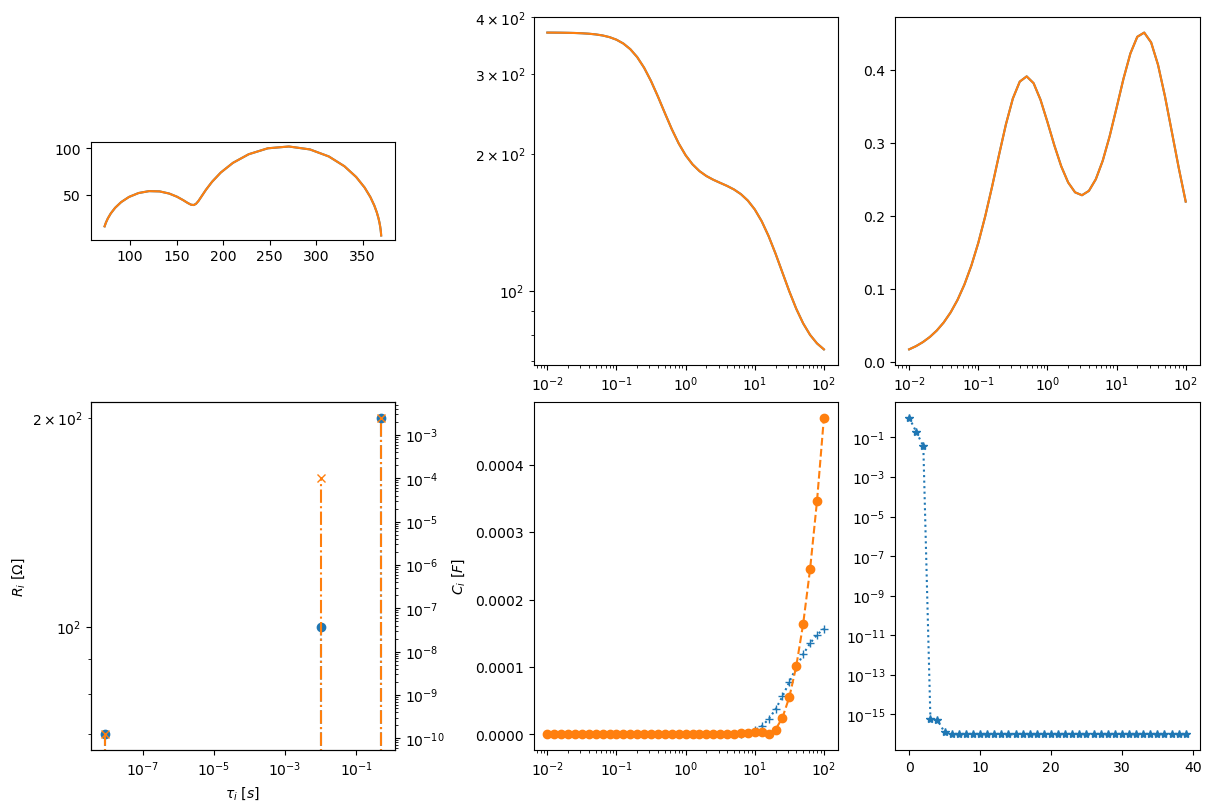

In [6]:
Z_plot = Z_sim
H_plot = H
R_plot = R_i
C_plot = C_i
tau_plot = tau_i
res_ReZ_plot = res_ReZ
res_ImZ_plot = res_ImZ
svd_L_plot = svd_L
DRT_Single_Plot(f, Z_plot, H_plot, R_plot, C_plot, tau_plot, res_ReZ_plot, res_ImZ_plot, svd_L_plot)

In [7]:
# Z_plot = Z_sim_noise
# H_plot = H_n
# R_plot = R_n
# C_plot = C_n
# tau_plot = tau_n
# res_ReZ_plot = res_ReZ_n
# res_ImZ_plot = res_ImZ_n
# svd_L_plot = svd_L_n
# DRT_Single_Plot(f, Z_plot, H_plot, R_plot, C_plot, tau_plot, res_ReZ_plot, res_ImZ_plot, svd_L_plot)

In [8]:
# tau_r = np.abs(tau_n.real / tau_n.imag)
# plt.figure()
# ax1 = plt.subplot(211)
# ax1.loglog(tau_i, R_i, 'o', label='R_i')
# ax1.loglog(tau_n[tau_r>1].real, R_n[tau_r>1].real, '*', label='R_n')
# ax1.legend()

# ax2 = plt.subplot(212)  
# ax2.loglog(tau_i, C_i, 'ro', label='C_i')
# ax2.loglog(tau_n[tau_r>1], C_n[tau_r>1], '*', label='C_n')
# ax2.legend()


# Data Loader

## Definition

In [9]:
def SearchELE(rootPath, ele_pattern = re.compile(r"(.+?)_归档")):
    '''==================================================
        Search all electrode directories in the rootPath
        Parameter: 
            rootPath: current search path
            ele_pattern: electrode dir name patten
        Returen:
            ele_list: list of electrode directories
        ==================================================
    '''
    ele_list = []
    for i in os.listdir(rootPath):
        _path = os.path.join(rootPath, i)
        if os.path.isdir(_path):
            match_ele = ele_pattern.match(i)
            if match_ele:
                ele_list.append([_path, match_ele.group(1)])
            else:
                ele_list.extend(SearchELE(_path, ele_pattern))

    return ele_list

In [10]:
def setup_logger(log_dir="./LOG", log_filename="file.log", file_level="WARNING", console_level="WARNING"):
    # 创建目录
    os.makedirs(log_dir, exist_ok=True)
    log_fd = os.path.join(log_dir, log_filename)

    logger.remove()
    # 如果已有日志文件，重命名添加时间戳
    if os.path.exists(log_fd):
        name, ext = os.path.splitext(log_filename)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        archived_name = f"{name}_{timestamp}{ext}"
        archived_path = os.path.join(log_dir, archived_name)
        os.rename(log_fd, archived_path)

    # 添加终端输出
    logger.add(sys.stdout, level=console_level, enqueue=True)

    # 添加文件输出
    logger.add(log_fd, level=file_level, encoding="utf-8", enqueue=True)

    return logger

## Run

In [11]:
if False:
    setup_logger(log_dir="D:\Baihm\EISNN\LOG\DRT_Process_Log")

# logger.remove()
# logger.add(sys.stdout, level="WARNING")
# logger.add("./LOG/file.log", rotation="10 MB", level="INFO")

In [12]:

# rootPath = "D:/Baihm/EISNN/Archive/"
# ele_list = SearchELE(rootPath)
# DATASET_SUFFIX = "Outlier_Ver04"

rootPath = "D:/Baihm/EISNN/Archive_New/"
ele_list = SearchELE(rootPath)
DATASET_SUFFIX = "Outlier_Ver04"

# rootPath = "D:/Baihm/EISNN/Invivo/"
# ele_list = SearchELE(rootPath, re.compile(r"(.+?)_Ver02"))
# DATASET_SUFFIX = "Outlier_Ver04"


n_ele = len(ele_list)
logger.info(f"Search in {rootPath} and find {n_ele:03d} electrodes")

2025-07-04 01:39:24.055 | INFO     | __main__:<module>:15 - Search in D:/Baihm/EISNN/Archive_New/ and find 187 electrodes


In [13]:
# freq_list = np.linspace(1000,5000-1,101,dtype=int, endpoint=True)
freq_list = np.linspace(0,5000-1,101,dtype=int, endpoint=True)
freq_list = freq_list[1:]

DRT_SUFFIX = f"{DATASET_SUFFIX}_DRT_Ver01"
SAVE_FLAG = True
FORCE_FLAG = True

In [14]:
RUN_FLAG = True
if RUN_FLAG:
    for i in range(n_ele):
    # for i in range(0,1):
        # logger.info(f"ELE Begin: {ele_list[i][0]}")
        fd_pt = os.path.join(ele_list[i][0], DATASET_SUFFIX, f"{ele_list[i][1]}_{DATASET_SUFFIX}.pt")
        if not os.path.exists(fd_pt):
            logger.warning(f"{fd_pt} does not exist")
            continue
        
        data_pt = torch.load(fd_pt)
        _meta_group = data_pt["meta_group"]
        _data_group = data_pt["data_group"]


        ele_id  = _meta_group["ele_id"]
        elePath = _meta_group["elePath"]
        n_ch = _meta_group["n_ch"]      
        x_day_full = _meta_group["TimeSpan"]


        logger.warning(f"ELE[{i+1}/{n_ele}]: \t{ele_id} - {elePath}")


        # Storage path
        save_dir = f"{elePath}/{DRT_SUFFIX}/"
        pt_file_name = f"{ele_id}_{DRT_SUFFIX}.pt"
        os.makedirs(save_dir, exist_ok=True)
        if os.path.exists(os.path.join(save_dir, pt_file_name)):
            logger.warning(f"FileAlreadyExistsWarning: {ele_id} - {pt_file_name} already exists.")
            if SAVE_FLAG and not FORCE_FLAG:
                continue


        for j in _data_group['Channels']:
            try:
            # if 1:
                logger.info(f"ELE[{ele_id}] - ch[{j:03d}] Begin") 
                channel_group_raw = _data_group[j]

                
                chData      = channel_group_raw['chData']         
                eis_seq     = channel_group_raw['eis_seq']        
                eis_cluster = channel_group_raw['eis_cluster']    
                eis_anomaly = channel_group_raw['eis_anomaly']    

                if chData.shape[2] != 5000:
                    logger.error(f"ELE[{ele_id}] - ch[{j}] with less than 5000 samples")
                    break
                
                chData = chData[:, :, freq_list]
                chData = chData[eis_seq, :, :]

                # Run DRT Analysis
                
                DRTdata = DRT_Analysis_Batch(chData, REALFLAG=True)
                # logger.info(f"ELE[{ele_id}] - ch[{j:03d}] DRT Finished")
                
                # Plot DRT Analysis Results
                fig = plt.figure(figsize=(16, 9), constrained_layout=True)
                DRT_Plot_Batch(fig, DRTdata, chData)
                fig.suptitle(f"ELE[{ele_id}] - ch[{j:03d}] DRT Analysis", fontsize=16, fontweight='bold')


                # Save Fig
                fig_name = f"DRT_{ele_id}_ch{j:03d}.png"
                
                os.makedirs(save_dir, exist_ok=True) 
                path = os.path.join(save_dir, fig_name)

                fig.savefig(path)
                plt.close(fig) 

                # Data Saving
                channel_group_DRT = {}
                channel_group_DRT['chData']   = chData
                channel_group_DRT['DRTdata']  = DRTdata

                _data_group[j] = channel_group_DRT
                logger.info(f"ELE[{ele_id}] - ch[{j:03d}] Finished")
                
                
            except Exception as e:
                logger.error(f"ELE[{ele_id}] - ch[{j:03d}] Run with error: {e}")
                continue

        
        pt_store = {}
        pt_store["meta_group"] = _meta_group
        pt_store["data_group"] = _data_group
        if SAVE_FLAG:
            torch.save(pt_store, os.path.join(save_dir, pt_file_name))




C:\Users\Baihm\AppData\Local\Temp\4\ipykernel_32168\1194803541.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_pt = torch.load(fd_pt)
2025-07-04 01:39:27.462 | WAR

c:\Users\Baihm\anaconda3\envs\EISNN\Lib\site-packages\ipykernel\eventloops.py:145: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  el.exec() if hasattr(el, "exec") else el.exec_()


# Viewer

In [15]:
VIEWER_FLAG = True
if VIEWER_FLAG:
    # ele_id = "02067447"
    # ch_id = 16    # Short with two phased
    # ch_id = 68    # Short Type II

    
    ele_id = "06017758"
    ch_id = 10    # Perfect

    
    # ele_id = "01037160"
    # ch_id = 20    # Short type I

    
    # ele_id = "11057712"
    # # ch_id = 26      # Normal to Short
    # ch_id = 107      # Normal to Short
    
    fd_pt = f"D:/Baihm/EISNN/Archive/{ele_id}_归档\\Outlier_Ver04_DRT_Ver01\\{ele_id}_Outlier_Ver04_DRT_Ver01.pt"

    # Read out
    data_pt = torch.load(fd_pt)
    _data_group = data_pt["data_group"]
    chData = _data_group[ch_id]['chData']
    DRTdata = _data_group[ch_id]['DRTdata']
    
    # Plot
    fig = plt.figure(figsize=(16, 9), constrained_layout=True)
    DRT_Plot_Batch(fig, DRTdata[:], chData[:,:,:])
    # DRT_Plot_Batch_3D(fig, DRTdata[:2], chData[:2,:,:])



C:\Users\Baihm\AppData\Local\Temp\4\ipykernel_32168\983436853.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_pt = torch.load(fd_pt)


In [16]:
# fig = plt.figure(figsize=(16, 9), constrained_layout=True)
            
# DRT_Plot_Batch_3D(fig, DRTdata, chData)
            